<a href="https://colab.research.google.com/github/lucasfurtt/profitpreview/blob/main/profit_preview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

# Previsão de lucro para um e-commerce

O projeto disposto abaixo tem como intenção a criação de um modelo de machine learning capaz de prever lucros e prejuízos de uma empresa de e-commerce. Para se criar o modelo, será utilizada uma base de dados que contém informações sobre as vendas dessa empresa.

Hipótese: É possível fazer um modelo capaz de prever qual será o profit da venda praticada?

Conclusão: Sim, é possível fazer um modelo capaz de prever o profit de acordo com os atributos de venda. Nesse projeto, foram feitos testes com 3 modelos: regressão linear, SVR e Random Forest Regressor.

O modelo que teve o melhor resultado foi o Random Forest Regressor. Porém, o seu valor de R², de 0,41, ainda não é satisfatório para poder colocar o modelo em produção. Isso pode ser explicado pela baixa quantidade de obsevações do modelo, comparada com a quantidade de atributos necessários após o uso do processo de one-hot-encoding. De modo geral, o que sugeriria nesse caso é uma revisão dos dados fornecidos. Como sugestão, deixo duas possibilidades a serem realizadas: recolher mais dados junto com a área comercial da empresa de e-commerce, para gerar um modelo que pode ser treinado de forma mais profunda; o uso do recurso de tuning parameters, principalmente nos modelos de RFR e SVR.

A tecnologia não deve ser usada pela tecnologia. Ela deve ser usada para gerar valor ao negócio, e para isso acontecer, é preciso entender o problema do cliente e se o modelo a ser utilizado irá resolvê-lo ou não. Com a obtenção de mais dados com o cliente, o modelo tende a ficar mais preciso, facilitando assim análises futuras.

**Visão inicial dos dados de venda**

In [ ]:
df = pd.read_csv('/content/dados.csv', index_col=False)
df.head()

,Order_ID,Order_Priority,Order_Quantity,Sales,Ship_Mode,Profit,Customer_Name,Region,Customer_Segment,Product_Category,Product_Sub-Category,Product_Name,Product_Container
0,643,High,21,2781.82,Express Air,-695.26,Monica Federle,Nunavut,Corporate,Office Supplies,Storage & Organization,"SAFCO Commercial Wire Shelving, Black",Large Box
1,8995,High,35,3389.93,Express Air,737.94,Beth Paige,Northwest Territories,Consumer,Furniture,Office Furnishings,Luxo Professional Combination Clamp-On Lamps,Large Box
2,9127,Not Specified,7,2039.56,Express Air,-329.49,Bryan Davis,Northwest Territories,Corporate,Office Supplies,Storage & Organization,"Tennsco Snap-Together Open Shelving Units, Sta...",Large Box
3,26272,Low,6,905.94,Express Air,-4.19,Carlos Daly,Northwest Territories,Home Office,Furniture,Chairs & Chairmats,Hon Olson Stacker Stools,Large Box
4,36646,Medium,24,1168.15,Express Air,-743.96,Muhammed MacIntyre,Northwest Territories,Small Business,Office Supplies,Storage & Organization,Tennsco Industrial Shelving,Large Box


Quantidade de dados da base

O dataset tem 730 linhas e 13 colunas.

In [ ]:
df.shape

(730, 13)

Visão geral - Tipos dados e existência ou não de dados nulos
    
Através da visão geral da base de dados, podemos perceber que não há valores nulos. Portanto, inicialmente não há necessidade de se filtrar linhas ou preenchê-las com base em estatística (média ou mediana). A base usada para o modelo provavelmente será igual a inicial.

O dataset aparenta estar com dados consistentes, mas vamos explorar um pouco mais a fundo para entender que dados estão sendo preenchidos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Order_ID              730 non-null    int64  
 1   Order_Priority        730 non-null    object 
 2   Order_Quantity        730 non-null    int64  
 3   Sales                 730 non-null    float64
 4   Ship_Mode             730 non-null    object 
 5   Profit                730 non-null    float64
 6   Customer_Name         730 non-null    object 
 7   Region                730 non-null    object 
 8   Customer_Segment      730 non-null    object 
 9   Product_Category      730 non-null    object 
 10  Product_Sub-Category  730 non-null    object 
 11  Product_Name          730 non-null    object 
 12  Product_Container     730 non-null    object 
dtypes: float64(2), int64(2), object(9)
memory usage: 74.3+ KB


Visão dos dados preenchidos - Quantidade de valores

Vamos verificar que valores estão sendo mais praticados dentro das colunas textuais.

In [ ]:
colunas_string = ['Ship_Mode','Customer_Name','Region','Customer_Segment','Product_Category','Product_Sub-Category','Product_Name','Product_Container']
df_string = df[colunas_string]
for coluna in df_string.columns:
    contagem = df_string[coluna].value_counts()
    print(coluna)
    print(contagem.to_string())

Ship_Mode
Ship_Mode
Regular Air    579
Express Air    151
Customer_Name
Customer_Name
Sally Knutson             19
Jack Lebron               17
Joy Smith                 16
Erica Bern                13
Bill Donatelli            13
Hilary Holden             13
Shahid Shariari           13
Lela Donovan              12
Justin Hirsh              12
Justin Knight             12
Carlos Soltero            12
Ralph Kennedy             11
Sylvia Foulston           10
Doug Bickford             10
Alan Barnes               10
Guy Armstrong              9
Sonia Sunley               9
Liz Price                  9
Dorothy Wardle             9
Rob Dowd                   9
Rob Haberlin               9
Greg Guthrie               8
Roy Skaria                 8
Grant Carroll              8
Kristina Nunn              8
Mark Cousins               7
Guy Thornton               7
Carlos Daly                7
Luke Weiss                 7
Giulietta Weimer           7
Meg O'Connel               7
Bruce Stewart  

A visão dos valores que mais aparecem em cada coluna não ficou interessante com o uso do value_counts(). Para ajudar a análise exploratória, é interessante fazer um gráfico de barras e entender visualmente os valores que mais aparecem nas colunas textuais.

Através dos gráficos dispostos abaixo, podemos fazer as seguintes observações:
       
        1) Ship_Mode: o modelo de envio mais praticado pelo e-commerce é o Regular Air.
        2) Customer_Name: o número máximo de compras para um mesmo cliente é de 19 vendas. Os 10 clientes que mais compraram no e-commerce ao total somam 140 vendas, representando por volta de 20% do total de vendas praticadas. Esse dado pode ser interessante para o analista de negócio.
        3) Region: a região em que mais há venda é a West, tendo 7x mais vendas que a região que menos vende, Nuvant.
        4) Customer_Segment: a maioria dos clientes vem do segmento corporativo. Comparado com os outros 3 segmentos existentes somados na base de dados, o segmento corporativo representa 70% das vendas do negócio.
        5) Product_Category: A categoria de produto que mais vende é a de suprimentos de escritório, representando um total de 60% das vendas; logo atrás, aparece a categoria de tecnologia, representando 25% das vendas do e-commerce; por fim, mobílias representam 15% do negócio. A categoria de suprimentos de escritório tem mais vendas que as duas outras somadas.
        6) Product_Sub-Category: A sub-categoria de produtos descreve mais especificamente o produto vendido. Nesse quesito, 7 sub-categorias venderam mais que 50 produtos. Os produtos que mais se destacam são encadernados e papel.
        7) Product_Name: A categoria de nome do produto trás um dado surpreendente. Não há nenhum produto com mais de 5 vendas. Ou seja, o máximo que um produto pode representar do total de vendas é 0,68%.
        8) Product_Container: A categoria de recipiente (ou embalagem) do produto revela que 83% das vendas praticadas são enviadas em recipientes pequenos.

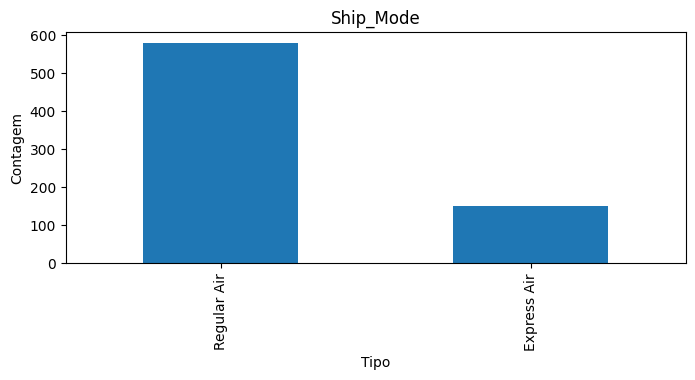

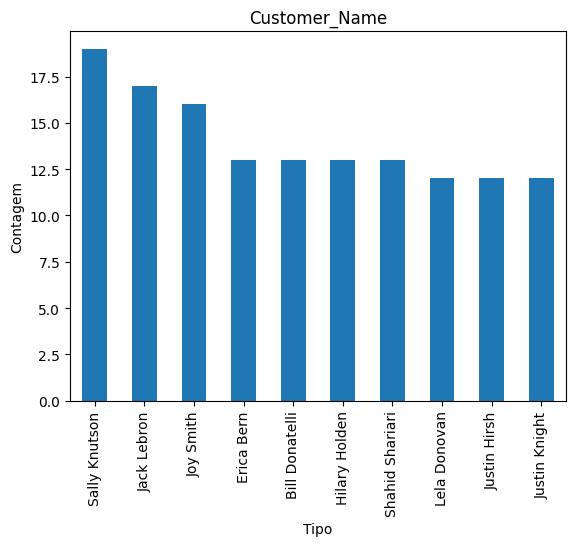

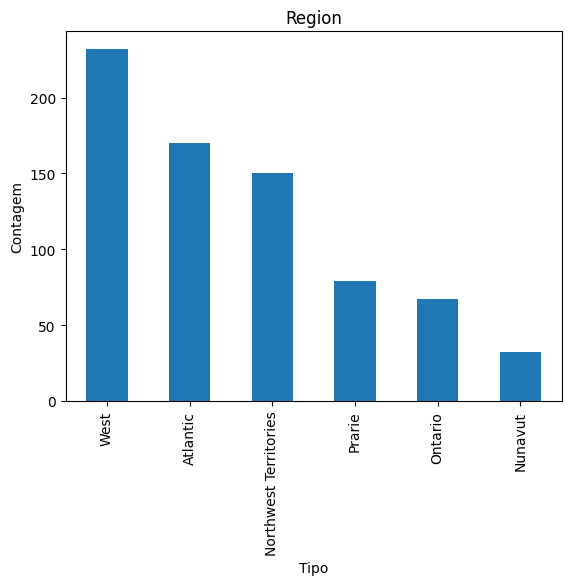

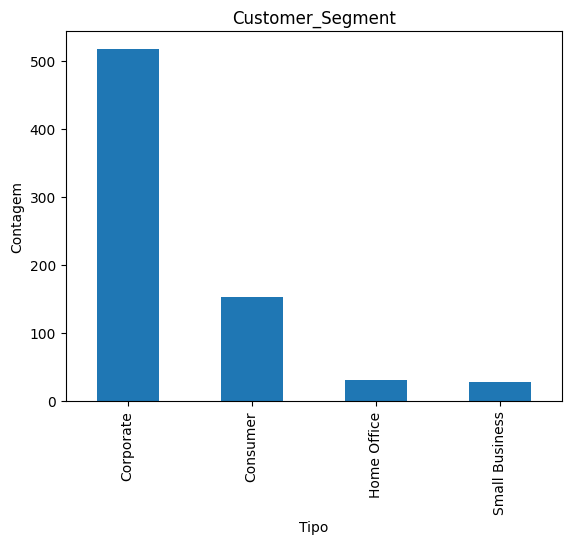

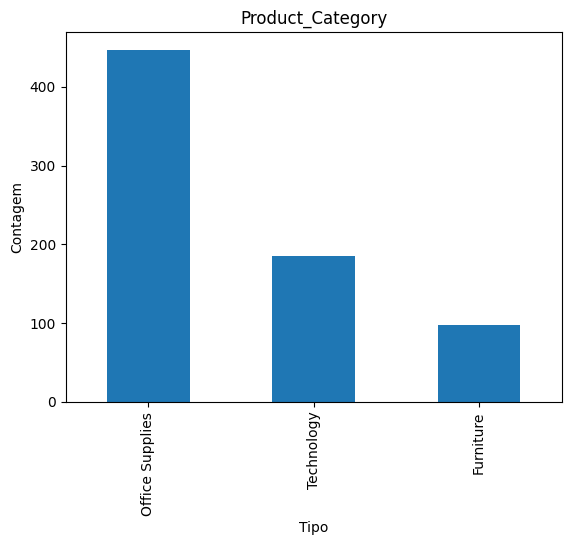

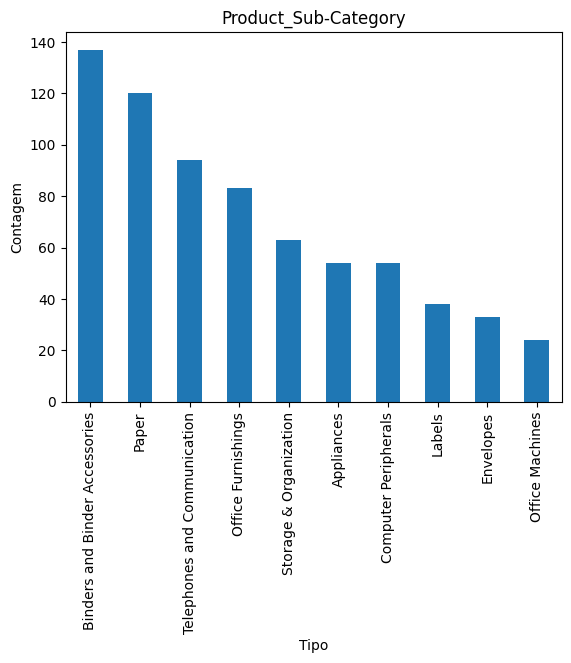

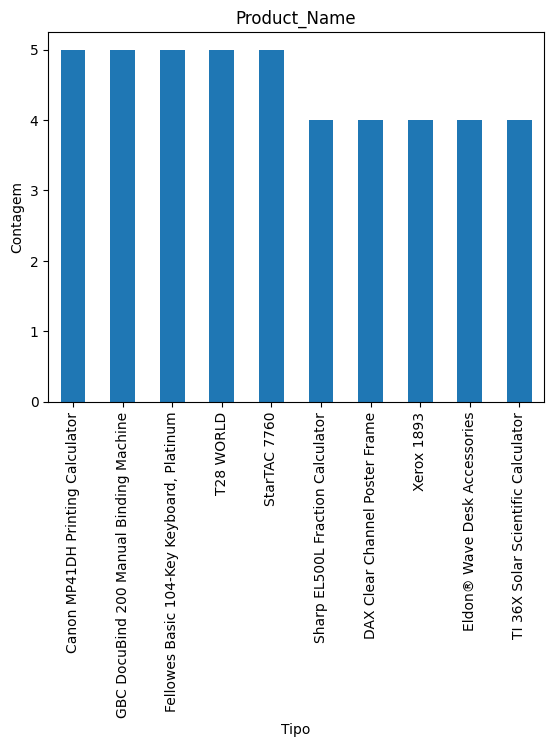

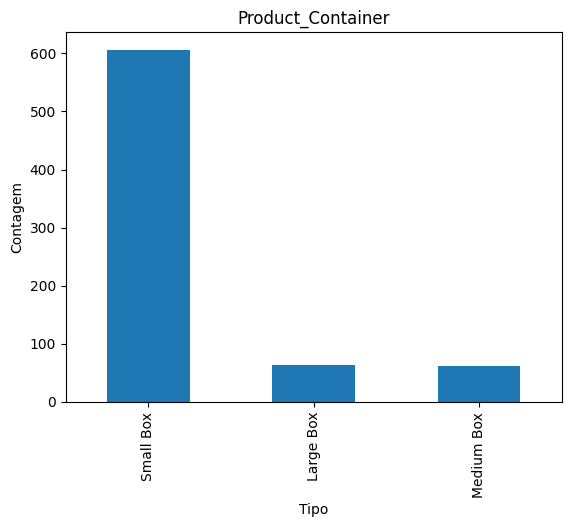

In [ ]:
plt.figure(figsize=(8, 3))
for coluna in df_string.columns:
    contagem = df_string[coluna].value_counts().head(10)  #10 valores que mais aparecem
    contagem.plot(kind='bar', title=coluna)
    plt.xlabel('Tipo')
    plt.ylabel('Contagem')
    plt.show()

Vamos entender como se comporta a coluna Profit por sub-categoria de produto.

In [ ]:
subcategoria_profit = df.groupby('Product_Sub-Category')["Profit"].sum()
subcategoria_profit

Product_Sub-Category
Appliances                        22731.86
Binders and Binder Accessories    26291.74
Chairs & Chairmats                12164.94
Computer Peripherals               4982.06
Copiers and Fax                    1561.39
Envelopes                          6049.97
Labels                             1296.60
Office Furnishings                 8700.26
Office Machines                   26832.43
Paper                              3124.64
Pens & Art Supplies                 -93.30
Scissors, Rulers and Trimmers     -1759.58
Storage & Organization            -4567.98
Tables                            -3847.36
Telephones and Communication      47992.17
Name: Profit, dtype: float64

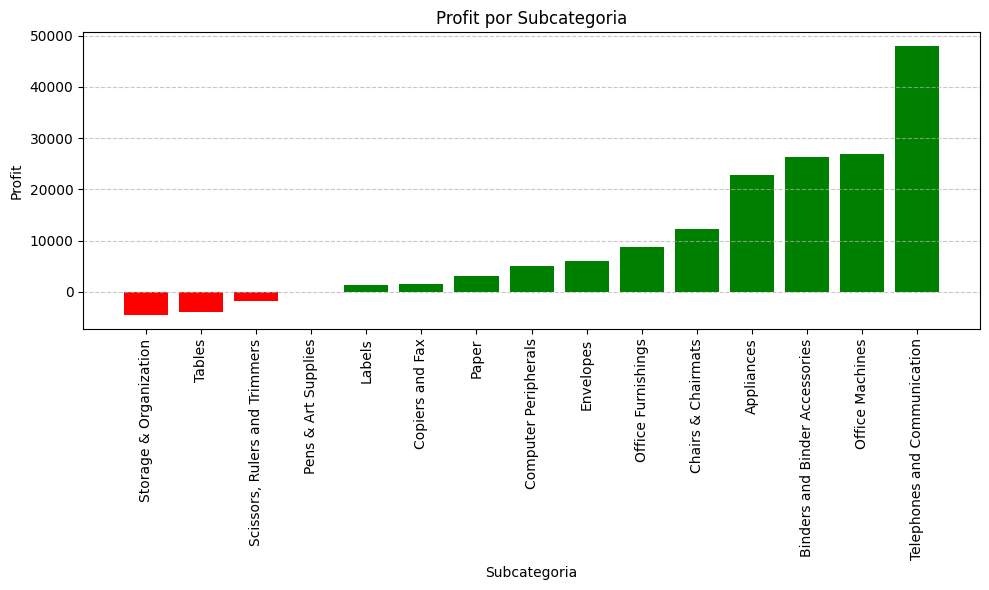

In [ ]:
subcategoria_profit = subcategoria_profit.reset_index()

subcategoria_profit = subcategoria_profit.sort_values(by='Profit')

plt.figure(figsize=(10, 6))
plt.bar(subcategoria_profit['Product_Sub-Category'], subcategoria_profit['Profit'], color=['red' if x < 0 else 'green' for x in subcategoria_profit['Profit']])
plt.xlabel('Subcategoria')
plt.ylabel('Profit')
plt.title('Profit por Subcategoria')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Visão de dados estatísticos sobre a base

Primeiro, vamos ter uma visão geral sobre a base através do método describe. Para essa visão estatística, filtrarei apenas os valores numéricos que representam dados (não considerarei o ID). Com ele, podemos perceber que a média de lucro geral é de 207, sendo o valor médio de venda de 1502, sendo o lucro 13% desse valor. Porém, percebemos que o desvio padrão de vendas é na casa de 2893, e o lucro tendo um desvio padrão de 878, valores consideravelmente altos para a base, principalmente quando comparado ao valor da média. É interessante ver como essa base de dados se comporta num gráfico de boxplot.

In [ ]:
colunas_para_analise = ['Order_Quantity', 'Sales', 'Profit']
df_quantitativo = df[colunas_para_analise]
df_quantitativo.describe()

,Order_Quantity,Sales,Profit
count,730.000000,730.000000,730.000000
mean,24.857534,1502.777653,207.479233
std,14.182970,2893.936648,878.631028
min,1.000000,8.600000,-4437.910000
25%,13.000000,171.098375,-77.132500
50%,25.000000,438.700000,0.035000
75%,37.000000,1480.855000,180.000000
max,50.000000,27663.920000,8417.570000


Através da disposição dos dados em um boxplot, percebemos que as colunas de vendas e lucro tem um cenário interessante: seus quartis são reduzidos em relação a quantidade de outliers dispostos na base. A maioria desses dados são assimétricos positivos (ou seja, a sua mediana tende para um valor menor comparado ao máximo).

A quantidade de outliers nessa base dados está bastante alta. O ideal, nesse caso, seria ter uma conversa com os donos do negócio para entender como esses dados de venda foram recolhidos, a fim de possibilitar a revisão dessa base de dados. Uma segunda análise com os dados revisados pelos donos do negócio seria uma boa continuidade ao projeto.

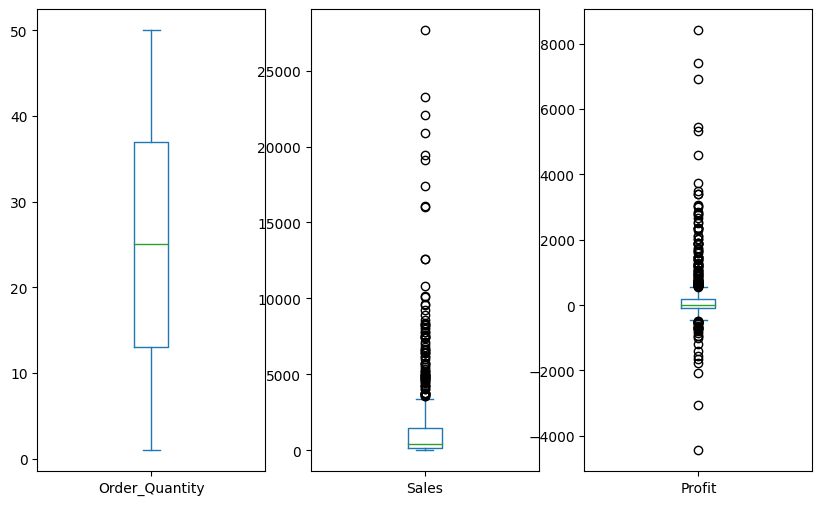

In [ ]:
df_quantitativo.plot(kind='box', figsize=(10,6), subplots=True);

Após a visualização dos nossos dados em boxplot, vamos ver quantas linhas de vendas e lucro são outliers. Dessa forma, percebemos que em relação a coluna Sales, 85 linhas são outliers. Já em relação a coluna Profit, 136 linhas são consideradas outliers.

In [ ]:
#quartis
Q1_l = df['Profit'].quantile(0.25)
Q3_l = df['Profit'].quantile(0.75)
Q1_v = df['Sales'].quantile(0.25)
Q3_v = df['Sales'].quantile(0.75)
#cálculo do intervalo interquartil
IQR_l = Q3_l - Q1_l
IQR_v = Q3_v - Q1_v

#definir os limites para identificar outliers
limite_inferior_l = Q1_l - 1.5 * IQR_l
limite_superior_l = Q3_l + 1.5 * IQR_l
limite_inferior_v = Q1_v - 1.5 * IQR_v
limite_superior_v = Q3_v + 1.5 * IQR_v

#definição de outliers
outliers_l = df[(df['Profit'] < limite_inferior_l) | (df['Profit'] > limite_superior_l)]
outliers_v = df[(df['Sales'] < limite_inferior_v) | (df['Sales'] > limite_superior_v)]

#contagem de outliers
numero_de_outliers_l = len(outliers_l)
numero_de_outliers_v = len(outliers_v)

print("Número de outliers de vendas:", numero_de_outliers_v)
print("Número de outliers de lucro:", numero_de_outliers_l)

Número de outliers de vendas: 85
Número de outliers de lucro: 136


A nossa análise exploratória da base nos permitiu chegar a algumas conclusões sobre a base de dados.

    1) Não há valores nulos na base de dados;
    2) Não há valores preenchidos erroneamente nas colunas (exemplo, preencher o tipo de envio na coluna de vendas);
    3) O tipo de envio mais praticado é o Regular Air;
    4) A região que mais vende é a West;
    5) Apesar de a categoria de produtos de escritório se destacar na base de dados, não há um produto específico que se destaque: o número máximo de vendas de um mesmo produto é de 5.
    6) Apesar da base de dados ter uma boa saúde de preenchimento, o resultado das análises estatísticas indicam uma base de dados pouco simétrica e com grande presença de outliers. Esses valores discrepantes podem enviesar a nossa análise.

Dessa forma, um caminho interessante a se seguir é treinar sem os outliers, podendo ver assim se a presença dos outliers impacta o treinamento do nosso modelo.

Agora temos a base de dados 'df', representando os dados vindos do negócio com os valores discrepantes, tendo no total 730 linhas. Além disso, também temos a base de dados 'df_filtrado", com 585 linhas, nas quais foram filtrados valores considerados outliers na nossa análise exploratória.

In [ ]:
#criação de base de dados sem outliers
df_filtrado = df[(df['Sales'] < limite_superior_v) & (df['Sales'] > limite_inferior_v) &
                 (df['Profit'] < limite_superior_l) & (df['Profit'] > limite_inferior_l)]

In [ ]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 585 entries, 2 to 729
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Order_ID              585 non-null    int64  
 1   Order_Priority        585 non-null    object 
 2   Order_Quantity        585 non-null    int64  
 3   Sales                 585 non-null    float64
 4   Ship_Mode             585 non-null    object 
 5   Profit                585 non-null    float64
 6   Customer_Name         585 non-null    object 
 7   Region                585 non-null    object 
 8   Customer_Segment      585 non-null    object 
 9   Product_Category      585 non-null    object 
 10  Product_Sub-Category  585 non-null    object 
 11  Product_Name          585 non-null    object 
 12  Product_Container     585 non-null    object 
dtypes: float64(2), int64(2), object(9)
memory usage: 64.0+ KB


Para iniciar a preparação dos nossos dados para o treinamento, precisamos transformar colunas textuais em números, para poder treinar e testar com alunos modelos de machine learning. Um processo possível de se usar é o de label (ou categorical) enconding, porém, no casso do nosso dataset, não temos colunas que representem ordens em seus dados. O uso do label enconding poderia confundir o modelo, considerando que por exemplo a Region que ele considerar como "1" é pior que a "6".

Em relação ao processo de one-hot-enconding, temos a possibilidade de aplicar a todas colunas textuais. Porém, em relação a coluna Product_Name, temos que ser um pouco mais cautelosos. Existem 485 valores exclusivos na coluna, sendo esses valores repetidos no máximo 5x em todo o dataset. Aplicar o processo de one-hot-enconding considerando esse coluna, significa ter 485 novas colunas para serem treinadas no modelo.

Vamos aplicar o one hot enconding considerando a coluna Product Name e verificar como fica a matriz de correlação do dataset.

In [ ]:
df_dummies = pd.get_dummies(df_filtrado, columns=['Order_Priority','Ship_Mode', 'Customer_Name', 'Region', 'Customer_Segment', 'Product_Category',
                                'Product_Sub-Category', 'Product_Name','Product_Container']
                   , drop_first = True) #o primeiro valor é retirado para diminuir o número de colunas

In [ ]:
df_dummies.shape

(585, 558)

Não vamos aplicar a correlação de Pearson por se tratar de um dataset pequeno e que não é normalmente distribuído. Vamos utilizar nesse caso a correlação de Spearman.

In [ ]:
correlacao = df_dummies.corr(method='spearman')
print(correlacao)

                              Order_ID  Order_Quantity     Sales    Profit  \
Order_ID                      1.000000        0.042913 -0.055881 -0.005833   
Order_Quantity                0.042913        1.000000  0.409102  0.028509   
Sales                        -0.055881        0.409102  1.000000  0.371417   
Profit                       -0.005833        0.028509  0.371417  1.000000   
Order_Priority_High           0.014364       -0.015208 -0.029994 -0.067646   
...                                ...             ...       ...       ...   
Product_Name_i1000           -0.043616        0.044732  0.066405  0.064689   
Product_Name_i470             0.008699       -0.009927  0.071060  0.060279   
Product_Name_i500plus        -0.043126        0.001716  0.053173  0.042146   
Product_Container_Medium Box  0.058434        0.008465  0.102783  0.061466   
Product_Container_Small Box  -0.050920        0.090779 -0.118445  0.011854   

                              Order_Priority_High  Order_Priori

Ao fazer o teste com a correlação de Spearman, percebe-se que em relação a coluna Profit (o target do nosso modelo), as colunas advindas de Product_Name através do processo de one_hot_encoding não são significantes, pois elas tem valores menores que 0,20 de correlação. Por tanto, vamos desconsiderá-las no nosso treino.

In [ ]:
df_filtrado = df_filtrado.drop(columns=['Product_Name'])

In [ ]:
df_dummies = pd.get_dummies(df_filtrado, columns=['Order_Priority','Ship_Mode', 'Customer_Name', 'Region', 'Customer_Segment', 'Product_Category',
                                'Product_Sub-Category','Product_Container', ]
                   , drop_first = True, dtype=int) #o primeiro valor é retirado para diminuir o número de colunas

In [ ]:
df_dummies.shape

(585, 190)

Portanto, sabemos que os nossos datasets de treino tem a seguinte forma:

    1) df_filtrado: 190 atributos e 585 observações. Nesse dataset não estão incluídos os outliers.
Vamos separar os nossos datasets em treino e teste. Para isso, consideraremos o valor de 20% da base para teste.

In [ ]:
X = df_dummies.drop("Profit", axis=1)
y = df_dummies["Profit"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=44)

Com os dados filtrados, podemos escolher os modelos que treinaremos e testaremos seus resultados. São eles:

    i) Linear Regression:
    ii) Support Vector Regression:
    iii) Random Forest Regression:

In [ ]:
modelos = {
    "Regressão Linear": LinearRegression(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor()
}

In [ ]:
parametros = {
    "Regressão Linear": {},
    "SVR": {},
    "Random Forest": {}
}

In [ ]:
resultados = {}
for nome, modelo in modelos.items():
    print(f"Treinando modelo {nome}...")
    grid = GridSearchCV(modelo, parametros[nome], scoring='neg_mean_squared_error', cv=5)
    grid.fit(X_train, y_train)
    resultados[nome] = grid
    print(f"Melhores parâmetros para {nome}: {grid.best_params_}")

Treinando modelo Regressão Linear...
Melhores parâmetros para Regressão Linear: {}
Treinando modelo SVR...
Melhores parâmetros para SVR: {}
Treinando modelo Random Forest...
Melhores parâmetros para Random Forest: {}


In [ ]:
print("\nAvaliação dos modelos:")
for nome, modelo in resultados.items():
    y_pred = modelo.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2_valor = r2_score(y_test, y_pred)
    print(f"{nome}: MSE = {mse}, R²{r2_valor}")


Avaliação dos modelos:
Regressão Linear: MSE = 2.732341593557796e+19, R²-1275164981462203.8
SVR: MSE = 21423.332860713737, R²0.0001878273711962697
Random Forest: MSE = 12634.112459934448, R²0.4103746830649364


In [ ]:
melhor_modelo = min(resultados, key=lambda x: mean_squared_error(y_test, resultados[x].predict(X_test)))
print(f"\nO melhor modelo é: {melhor_modelo}")


O melhor modelo é: Random Forest
